In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Import and clean data

In [2]:
data_file = 'data/Bleeding_Dataonly_For Chris.xlsx'

raw_data = (pd.read_excel(data_file, sheetname='Bleeding_Outcomes_AllKQs',
                         na_values=['null', 'ND'])
            .drop(['Comments', 'Other stats \nName','Other Stats','Results','Comments 2',
                   'Presentation \nlocation','Last Assesment tmpt for the study','Followup duration category'], 
                  axis=1)
            .rename(columns={'Outcome timepoint (when was this outcome measured, e.g., in PACU, 12 months post─op, immediately post─op──would need a row for each outcome at each timepoint of interest)': 'outcome_time',
                             'OUTC_Main_\nCATG':'outcome_cat',
                            "Outc_SUB_\nCATG":'outcome_subcat',
                            'OUTCOME SAMPLE SIZE': 'N',
                             'Outcome\ncount': 'outcome_obs',
                            'Outcome  \n%': 'outcome_pct',
                            "Outcome\n Mean": 'outcome_mean',
                            "Outcome \nSD": 'outcome_sd',
                             'Outcome \n SE': 'outcome_se',
                             'Outcome\n _Q1': 'outcome_q1', 
                             'Outcome \n_Q3': 'outcome_q3',
                            "Outcome \n Median": 'outcome_med',
                            "Outcome \n 95% L": 'outcome_lo_95',
                            "Outcome \n 95% H": 'outcome_hi_95',
                            "Outcome\n  Min": 'outcome_min', 
                             'Outcome \n Max': 'outcome_max'}))

raw_data.head()

,Citation,REFID,Child Paper,Number of Arms,Rx Grouping,Group_Desc,Intervention_category,Dose,Route,Rx_Durn,...,outcome_mean,outcome_sd,outcome_se,outcome_med,outcome_q1,outcome_q3,outcome_min,outcome_max,outcome_lo_95,outcome_hi_95
0,"K. Murto, C. Lamontagne, C. McFaul, J. MacCorm...",109,NaN,2,G1:,Celecoxib,Preoperative and postoperative NSAID,6 mg/kg and 3 mg/kg post-op,Oral,pre-op and post-op 5 days,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-7.0,8.0
1,"K. Murto, C. Lamontagne, C. McFaul, J. MacCorm...",109,NaN,2,G2:,Placebo,Placebo,6 mg/kg and 3 mg/kg post-op,Oral,pre-op and post-op 5 days,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"K. Murto, C. Lamontagne, C. McFaul, J. MacCorm...",109,NaN,2,G1:,Celecoxib,Preoperative and postoperative NSAID,6 mg/kg and 3 mg/kg post-op,Oral,pre-op and post-op 5 days,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.0,6.0
3,"K. Murto, C. Lamontagne, C. McFaul, J. MacCorm...",109,NaN,2,G2:,Placebo,Placebo,6 mg/kg and 3 mg/kg post-op,Oral,pre-op and post-op 5 days,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"H. S. Abdel-Ghaffar, H. G. Abdel-Azeem and M. ...",253,NaN,2,G1a:,Lornoxicam in one tonsil,perioperative NSAID,8 mg,Instillation/infiltration,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
raw_data['Intervention_category'] = raw_data.Intervention_category.str.lower().str.strip()
clean_data = raw_data.replace({'Intervention_category':{'saline':'control',
                        'control (no rx)':'control',
                        'control (no dexamethasone)':'control',
                        'no antibiotics':'control',
                        'no steroid':'control',
                        'placebo':'control'}})

Counts of bleeding outcomes by major category

In [4]:
clean_data.New_Bleeding_specify.value_counts()

Reoperation-bleeding            162
Revisit/Readmission-bleeding    150
Undefined bleeding              124
Secondary bleeding              110
Primary bleeding                110
Name: New_Bleeding_specify, dtype: int64

Here is the full list of intervention categories. For the purposes of this analysis, I will just use the ones with "total" or "partial" in the name, and take them to be surgical interventions.

In [5]:
clean_data.Intervention_category.value_counts()

total cold                                                127
total electrocautery                                      124
total coblation                                            69
control                                                    48
perioperative steroid                                      47
total harmonic scalpel                                     28
partial coblation                                          25
total molecular resonance                                  20
perioperative nsaid                                        17
partial laser                                              15
partial microdebrider                                      15
total laser                                                13
partial cold                                               13
total thermal welding                                      12
postoperative analgesic                                     9
total tonsillectomy - unspecified                           6
perioper

Here is the surgery filter:

In [6]:
surgery_data = clean_data[clean_data.Intervention_category.str.contains('total') 
                   | clean_data.Intervention_category.str.contains('partial')].dropna(subset=['outcome_obs']).copy()

List of interventions after filtering. Note that there were a lot of papers that did not report bleeding outcomes, so the numbers dropped significantly. 

**Which specific techniques should I be looking at, in particular?**

In [7]:
surgery_data.Intervention_category.value_counts()

total cold                                             74
total electrocautery                                   71
total coblation                                        34
total harmonic scalpel                                 22
partial coblation                                      13
total molecular resonance                              13
partial laser                                          12
total thermal welding                                  10
partial cold                                            7
partial microdebrider                                   6
total laser                                             6
total tonsillectomy - unspecified                       5
total argon plasma                                      3
total adenotonsillectomy - unspecified + no surgery     3
total electrocautery + total cold                       1
total adenotonsillectomy - unspecified                  1
total not specified                                     1
total microdeb

Indicator for partial

In [8]:
surgery_data['partial'] = surgery_data.Intervention_category.str.contains('partial')

For the first analysis, I will look at severe bleeding; that is, those requiring re-operation or re-admission.

In [9]:
severe_bleeding_data = surgery_data[surgery_data.New_Bleeding_specify.isin(['Revisit/Readmission-bleeding', 
                                                                            'Reoperation-bleeding'])]

Data fields used in analysis

In [10]:
N, REFID, events, partial = severe_bleeding_data[['N', 'REFID', 'outcome_obs', 'partial']].values.T

In [11]:
refid_list = list(set(REFID))
study_id = severe_bleeding_data.REFID.apply(lambda i: refid_list.index(i)).values
n_studies = len(refid_list)

Check for missing outcomes

In [12]:
assert not np.isnan(N.astype(int)).any()
assert not np.isnan(events.astype(int)).any()

Specify model

In [13]:
from pymc3 import (NUTS, sample, Model, Deterministic, find_MAP,
                  Binomial, Normal, HalfCauchy, advi,
                  traceplot, summary, forestplot)
import theano.tensor as tt

In [14]:
def tinvlogit(x):
    return tt.exp(x) / (1 + tt.exp(x))

with Model() as severe_bleeding_model:
    
    # Mean for intervention
    θ = Normal('θ', 0, sd=5, testval=-1)
    # Effect of partial intervention
    β = Normal('β', 0, sd=5, testval=0)
    
    # Study random effect
    σ = HalfCauchy('σ', 5, testval=1)
    ϵ = Normal('ϵ', 0, sd=σ, shape=n_studies, testval=np.zeros(n_studies))
    
    # Transform to probability scale
    π = tinvlogit(θ + β*partial.astype(int) + ϵ[study_id])
    
    # Mean probabilities
    π_total = Deterministic('π_total', tinvlogit(θ))
    π_partial = Deterministic('π_partial', tinvlogit(θ + β))
    
    # Data likelihood
    obs = Binomial('obs', N.astype(int), π, observed=events.astype(int))

Applied log-transform to σ and added transformed σ_log to model.


Model run using Hamiltonian Monte Carlo

In [15]:
with severe_bleeding_model:
    bleed_trace = sample(2000, random_seed=20090425)

Assigned NUTS to θ
Assigned NUTS to β
Assigned NUTS to σ_log
Assigned NUTS to ϵ
 [-----------------100%-----------------] 2000 of 2000 complete in 108.4 sec

Estimates show total removal by surgery to have approximately a 1.5% chance of severe bleeding; partial has approximately a 1% chance.

In [16]:
summary(bleed_trace[1000:], varnames=['π_total', 'π_partial'])


π_total:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.015            0.003            0.000            [0.009, 0.022]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.009          0.013          0.015          0.017          0.022


π_partial:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.009            0.004            0.000            [0.002, 0.018]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.003          0.006          0.008          0.011          0.020



/Users/fonnescj/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


Posterior traces and histograms of key parameters:

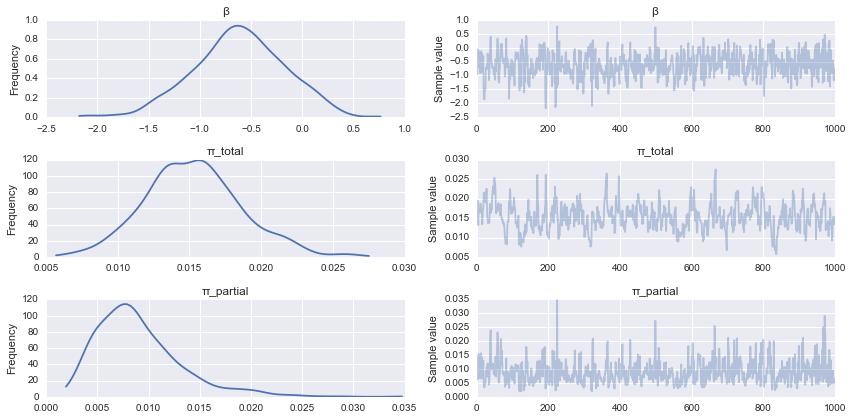

In [17]:
traceplot(bleed_trace[1000:], varnames=['β', 'π_total', 'π_partial']);

Study random effects. There is one strong outlier with a much higher rate of bleeding.

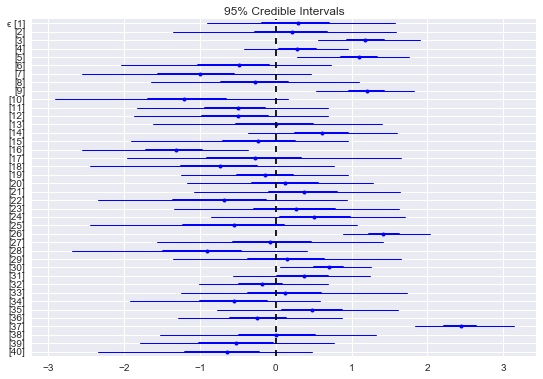

In [18]:
forestplot(bleed_trace[1000:], varnames=['ϵ'])